# Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='viridis')

In [2]:
# Set visualization parameters
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 250
sns.set_theme(style='darkgrid', palette='viridis')

In [3]:
# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/snehuuu28/Excelr_Data_Science/main/Assignments/Assignment_11/anime.csv")

In [4]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


# Data Preprocessing

In [5]:
# Check for missing values
print(df.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [6]:
# Handling missing values
df['genre'].fillna(df['genre'].mode()[0], inplace=True)  # Fill missing genres with mode
df['type'].fillna(df['type'].mode()[0], inplace=True)    # Fill missing types with mode
df['rating'].fillna(df['rating'].mean(), inplace=True)    # Fill missing ratings with mean


In [7]:
# Convert episodes to numeric values, coercing errors to NaN
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')

In [8]:
# Fill NaN episodes with a specific value (e.g., median)
df['episodes'].fillna(df['episodes'].median(), inplace=True)

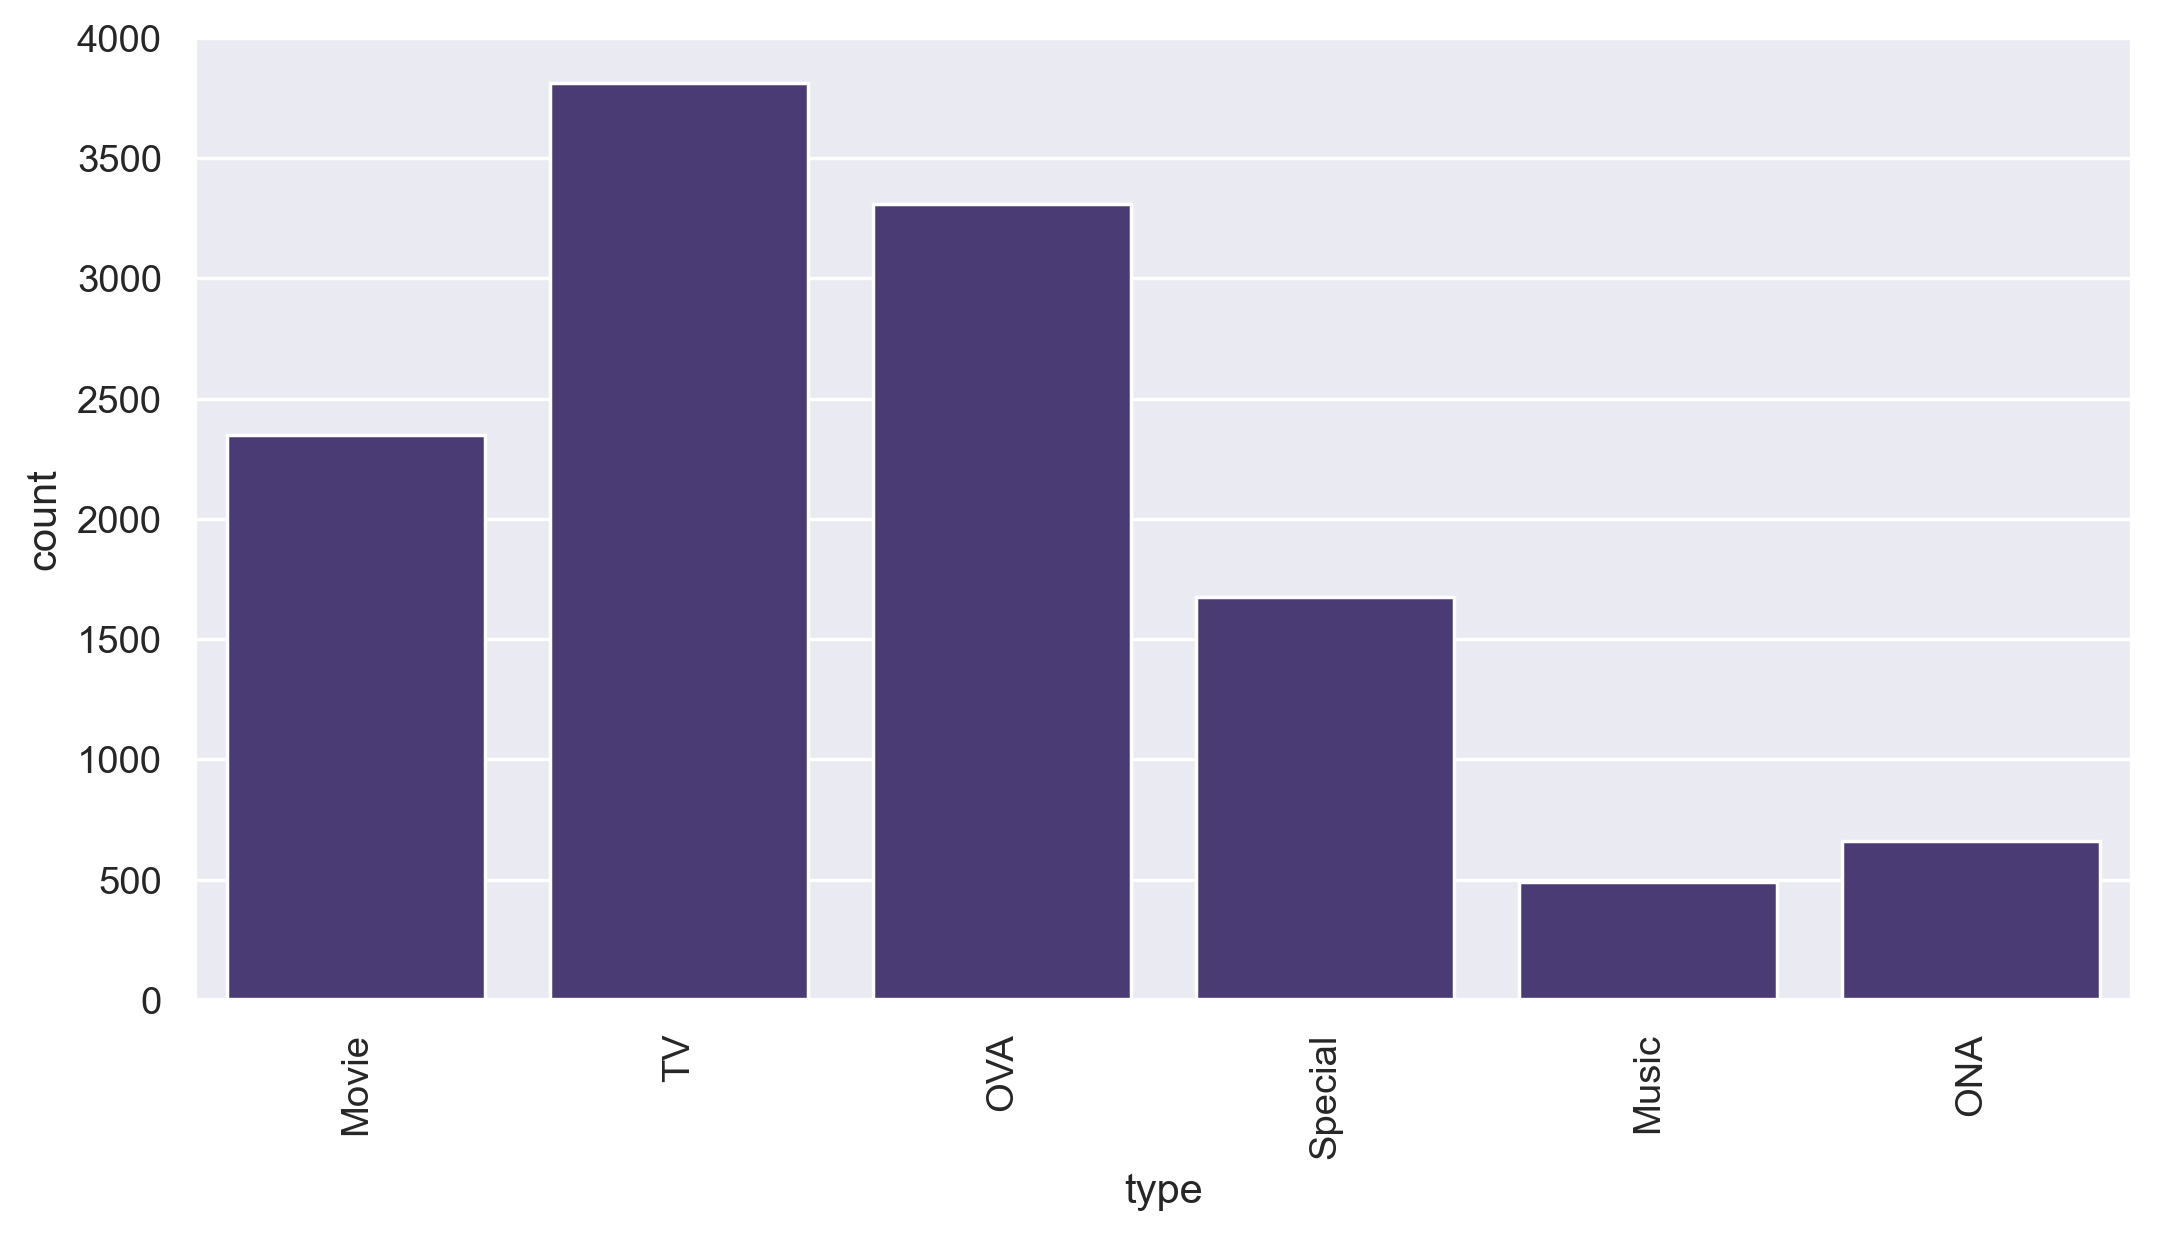

In [9]:
# Visualize the count of different anime types
sns.countplot(x = df['type'])
plt.xticks(rotation = 90)
plt.show()


# Feature Extraction

In [10]:
# One-Hot Encoding for categorical columns and scaling numeric columns
df_encoded = pd.get_dummies(df[['genre', 'type']], drop_first=True)

In [11]:
# Scale numerical features (rating, episodes, and members)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['rating', 'episodes', 'members']])

In [12]:
# Concatenate encoded genre/type with scaled numerical features
df_features = pd.DataFrame(df_scaled, columns=['rating', 'episodes', 'members'])
df_features = pd.concat([df_features, df_encoded], axis=1)

In [13]:
# Compute cosine similarity between all anime
cosine_sim = cosine_similarity(df_features)

# Recommendation System

In [14]:
# Recommendation function: Given a target anime, recommend similar anime
def recommend_anime(anime_id, cosine_sim, df, top_n=10):
    # Find the index of the anime from the anime_id
    idx = df.index[df['anime_id'] == anime_id].tolist()[0]

    # Get pairwise similarity scores for the target anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N similar anime (excluding the target anime itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Get the recommended anime names
    recommended_anime = df['name'].iloc[anime_indices]

    return recommended_anime

In [15]:
# Example usage of the recommendation function with a new anime_id
anime_id = 5678  # New example anime_id
recommended_anime = recommend_anime(anime_id, cosine_sim, df, top_n=10)

print(f"Recommended Anime for Anime ID {anime_id}:")
for idx, anime in recommended_anime.items():
    print(f"Anime ID: {idx}, Name: {anime}")

Recommended Anime for Anime ID 5678:
Anime ID: 4, Name: Gintama&#039;
Anime ID: 39, Name: Bakuman. 3rd Season
Anime ID: 75, Name: Ghost in the Shell: Stand Alone Complex 2nd GIG
Anime ID: 53, Name: Rainbow: Nisha Rokubou no Shichinin
Anime ID: 2, Name: Gintama°
Anime ID: 56, Name: Zoku Natsume Yuujinchou
Anime ID: 50, Name: Yojouhan Shinwa Taikei
Anime ID: 168, Name: Planetes
Anime ID: 14, Name: Haikyuu!! Second Season
Anime ID: 46, Name: Natsume Yuujinchou San


# Evaluation

In [16]:
# Train-Test Split for Evaluating the Recommendation System
train, test = train_test_split(df['anime_id'].unique(), test_size=0.2, random_state=42)

In [17]:
# Prepare train and test sets for evaluation
train_df = df[df['anime_id'].isin(train)]
test_df = df[df['anime_id'].isin(test)]


In [19]:
def evaluate_recommendation_system(test_df, cosine_sim, df, top_n=10):
    correct_recommendations = 0
    total_recommendations = 0

    for anime_id in test_df['anime_id'].unique():
        # Get recommendations for this anime_id
        recommended_anime = recommend_anime(anime_id, cosine_sim, df, top_n)

        # Check if any of the recommended anime are in the test set (considering them correct)
        if any(anime in test_df['name'].values for anime in recommended_anime):
            correct_recommendations += 1

        total_recommendations += 1

    # Calculate precision, recall, and F1-score
    precision = correct_recommendations / total_recommendations
    recall = correct_recommendations / test_df['anime_id'].nunique()
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Now call the function and print the results
precision, recall, f1 = evaluate_recommendation_system(test_df, cosine_sim, df)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.91
Recall: 0.91
F1-Score: 0.91


In [20]:
# Evaluate the recommendation system
evaluate_recommendation_system(test_df, cosine_sim, df, top_n=10)

(0.9137860919072793, 0.9137860919072793, 0.9137860919072793)

# Interpretation

* Precision: Out of all the recommendations made, about 91.38% are relevant to the user.

* Recall: Out of all the relevant anime in the test set, about 91.38% were recommended by the system.

* F1-Score: The F1-score is the harmonic mean of precision and recall, and it's close to 1, meaning the balance between precision and recall is well-maintained.